In [1]:
from scipy import ndimage, sparse
from scipy.linalg import eigh, inv, logm, norm
import scipy.sparse
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

from IPython.display import clear_output

In [2]:
def edges_rescaling(edges,scale): # edges are mat.data where mat is a sparse scipy matrix
    edges = np.log10(edges) # log rescale weights because they vary over many decades
    edges -= min(edges) # make them positive 
    edges /= max(edges)*1.0/scale # rescale from 0 to scale
    return edges

def build_omegaij(Kdata,Krow,Kcol,m):
    omegaIJ_data = np.zeros(Kdata.shape)
    omegaIJ_data = np.asfarray([Kdata[ind]*(1.0/m[Krow[ind]] + 1.0/m[Kcol[ind]]) for ind in range(omegaIJ_data.shape[0])])
    omegaIJ = sparse.coo_matrix((omegaIJ_data, (Krow, Kcol)), shape=(Krow.max()+1,Kcol.max()+1))
    return omegaIJ
def build_omegai(K,m):
    #0.5 to avoid double counting
    omegaI = 0.5*np.divide(K.sum(axis=1),m.reshape((m.shape[0],1)))
    return omegaI

def remove_col(mat,index_to_drop): #csr
    to_keep = list(set(range(mat.shape[1]))-set(index_to_drop))    
    mat = mat[:,to_keep]
    return mat
def remove_row(mat,index_to_drop): #csc
    to_keep = list(set(range(mat.shape[0]))-set(index_to_drop))    
    mat = mat[to_keep,:]
    return mat
def remove_2nodes(mat,nodes):
    mat = mat.tocoo()
    todrop1 = np.logical_or((mat.row==nodes[0]),(mat.row==nodes[1])).nonzero()[0]
    todrop2 = np.logical_or((mat.col==nodes[0]),(mat.col==nodes[1])).nonzero()[0]
    todrop = list(set(np.concatenate((todrop1,todrop2))))
    newdata=np.delete(mat.data,todrop)
    newrow=np.delete(mat.row,todrop)
    newcol=np.delete(mat.col,todrop)
    return sparse.coo_matrix((newdata, (newrow, newcol)), shape=mat.shape)
def remove_1node(mat,node):
    mat = mat.tocoo()
    todrop = np.logical_or((mat.row==node[0]),(mat.col==node[0])).nonzero()[0]
    todrop = list(set(todrop))
    newdata=np.delete(mat.data,todrop)
    newrow=np.delete(mat.row,todrop)
    newcol=np.delete(mat.col,todrop)
    return sparse.coo_matrix((newdata, (newrow, newcol)), shape=mat.shape)
def expand(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,idxs,m,g):
    for idx in idxs:
        newdata=K.data[idx]
        j=K.col[idx]
        Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol = expand1(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,newdata,m,g,j)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol
def expand1(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,newk,m,i,j):
    Kdata = np.append(Kdata,newk)
    Krow = np.append(Krow,i)
    Kcol = np.append(Kcol,j)
    omegaIJdata = np.append(omegaIJdata,newk*(1.0/m[i]+1.0/m[j]))
    omegaIJrow = np.append(omegaIJrow,i)
    omegaIJcol = np.append(omegaIJcol,j)
    #add symmetric
    Kdata = np.append(Kdata,newk)
    Krow = np.append(Krow,j)
    Kcol = np.append(Kcol,i)
    omegaIJdata = np.append(omegaIJdata,newk*(1.0/m[i]+1.0/m[j]))
    omegaIJrow = np.append(omegaIJrow,j)
    omegaIJcol = np.append(omegaIJcol,i)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol
def delete_nodes(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,idxs): #this is not symm wrt to (i,j)
    Kdata = np.delete(Kdata,idxs)
    Krow = np.delete(Krow,idxs)
    Kcol = np.delete(Kcol,idxs)
    omegaIJdata = np.delete(omegaIJdata,idxs)
    omegaIJrow = np.delete(omegaIJrow,idxs)
    omegaIJcol = np.delete(omegaIJcol,idxs)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol

In [9]:
filename='/home/garner1/Work/pipelines/tissue2graph/npz/mat_XY_10nn.npz'
data = np.load('/home/garner1/Work/pipelines/tissue2graph/npz/X-XY_data.npz',allow_pickle=True)

K0 = -1.0*sparse.load_npz(filename) #minus

# N = 10000
# K = K0.copy()[:N,:N].tocoo()  #make a copy of the initial data
# m = np.ones(K0.shape[0])[:N] #initial masses
# pos = data['XY'][:N,:]

K = K0.copy().tocoo()  #make a copy of the initial data
m = np.ones(K0.shape[0]) #initial masses
pos = data['XY']

#initialize omegaIJ/I
omegaIJ = build_omegaij(K.data,K.row,K.col,m)
omegaI = build_omegai(K,m) 

# delete very small entries  
# threshold = np.finfo(np.float).eps
threshold = 9.9999e-1

idxs_todelete = np.where(np.abs(K.data) < threshold)[0]
print(K.data.shape,K.row.max())
K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,idxs_todelete)
print(K.data.shape,K.row.max())

(10513250,) 1035993
(2627230,) 1035993


In [10]:
import networkx as nx
import seaborn as sns; sns.set()
sns.set(style='white', rc={'figure.figsize':(50,50)})

init_mat = sparse.coo_matrix((-1.0*K.data, (K.row, K.col)), shape=(K.row.max()+1, K.col.max()+1)) #minus

G = nx.from_scipy_sparse_matrix(init_mat) # if sparse matrix
eset = [(u, v) for (u, v, d) in G.edges(data=True)]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos,alpha=0.0)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r',style='solid')
plt.axis('off')

plt.savefig('./before_RG_minus.png',bbox_inches='tight')
plt.close()

# sns.set(style='white', rc={'figure.figsize':(10,10)})
# sns.distplot(weights)

In [11]:
%%time
'''RG flow'''
condition = True
Imax0 = 0
IJmax0 = 0
counter = 0
while condition:
    counter += 1
    #Find max btw node and edges
    IJmax_idx = np.where( omegaIJ.data==np.max(omegaIJ.data[np.nonzero(omegaIJ.data)]) )[0][0]
    i0 = np.where( omegaI==np.max(omegaI[np.nonzero(omegaI)]) )[0][0]
    Imax = omegaI[i0][0,0]
    IJmax = omegaIJ.data[IJmax_idx]
    maxtype = np.argmax([Imax,IJmax])
    condition = (abs(Imax-Imax0) > 1e-06) or (abs(IJmax-IJmax0) > 1e-06)
    Imax0 = Imax; IJmax0 = IJmax
#     clear_output()
    if Imax<=IJmax: #if edge
        print('edge removal')
        print(counter,[Imax,IJmax],np.count_nonzero(omegaI),omegaIJ.data.shape[0])
        i0 = K.row[IJmax_idx];j0 = K.col[IJmax_idx] #find max edge (i0,j0)  
        m = np.append(m,m[i0]+m[j0]) #add a center of mass node
        g = K.row.max()+1 # label the i0-j0 center of mass node
        pos = np.vstack((pos,[0.5*(pos[i0,0]+pos[j0,0]),0.5*(pos[i0,1]+pos[j0,1])]))
        idx_i0isrow = np.argwhere(K.row==i0) # idxs of (i0,j)
        idx_i0iscol = np.argwhere(K.col==i0) # idxs of (j,i0)
        idx_j0isrow = np.argwhere(K.row==j0) # idxs of (j0,i)
        idx_j0iscol = np.argwhere(K.col==j0) # idxs of (i,j0)
        js = np.setdiff1d([K.col[idx] for idx in np.union1d(idx_i0isrow,idx_j0isrow)],[i0,j0]) #nodes neighbours of i0 and j0
        for j in  js:
            idx_i0j = np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j))
            idx_j0j = np.intersect1d(np.argwhere(K.row==j0),np.argwhere(K.col==j))
            newk = np.sum(np.append(K.data[idx_i0j],K.data[idx_j0j]))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = expand1(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,newk,m,g,j)
            #remove i0 and j0 from K, omegaIJ
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j)))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==j),np.argwhere(K.col==i0)))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==j0),np.argwhere(K.col==j)))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==j),np.argwhere(K.col==j0)))
            #remove (i0,j0) from K, omegaIJ
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j0)))
            K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.intersect1d(np.argwhere(K.row==j0),np.argwhere(K.col==i0)))
        #update omegaI
        omegaI_g = np.array(sum([K.data[idx] for idx in np.argwhere(K.row==g)])*1.0/m[g]).reshape(1,1)
        omegaI = np.append(omegaI,omegaI_g,0)
        for j in js:
            omegaI[j] = sum([K.data[idx] for idx in np.argwhere(K.row==j)])*1.0/m[j]
        omegaI[i0] = 0.0; omegaI[j0] = 0.0
        
    if Imax>IJmax: #if node
        print('node removal')
        print(counter,[Imax,IJmax],np.count_nonzero(omegaI),omegaIJ.data.shape[0]) 
        idx_i0isrow = np.argwhere(K.row==i0) # idxs of (i0,j)
        idx_i0iscol = np.argwhere(K.col==i0) # idx of (i,i0)
        js = np.unique(K.col[idx_i0isrow]) # nn j in (i0,j)
        for i in js:
            for j in js[np.argwhere(js==i)[0][0]+1:]:
                idx_ij = np.intersect1d(np.argwhere(K.row==i),np.argwhere(K.col==j))
                idx_ji = np.intersect1d(np.argwhere(K.row==j),np.argwhere(K.col==i))
                idx_ii0 = np.intersect1d(np.argwhere(K.row==i),np.argwhere(K.col==i0))    
                idx_i0j = np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j))
#                 if idx_ij.shape[0]>0 and idx_ii0.shape[0]>0 and idx_i0j.shape[0]>0: # also if edge (i,j) exists
                if idx_ii0.shape[0]>0 and idx_i0j.shape[0]>0: # only if edge (i,i0) and (i0,j) exists
#minus here:
                    newk = np.sum(np.append(K.data[idx_ij],-1.0*K.data[idx_ii0]*K.data[idx_i0j]/(omegaI[i0]*m[i0])))
                    #update edge values
                    K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = expand1(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,newk,m,i,j)
                    #remove old (i,j) and (j,i)
                    K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,idx_ij)
                    K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,idx_ji)
        #remove i0 from K, omegaIJ
        K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.argwhere(K.row==i0))
        K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.argwhere(K.col==i0))
        #update omegaI
        for j in js:
            omegaI[j] = sum([K.data[idx] for idx in np.argwhere(K.row==j)])*1.0/m[j]
        #remove i0 omegaI
        omegaI[i0] = 0.0

node removal
1 [-1.660959053652734, -1.9999803074247755] 1035994 2627230
edge removal
2 [-0.3979381985360636, 1.2041236029278728] 1035993 2627228
edge removal
3 [-1.5, -1.4999999999999998] 1035992 2627226
edge removal
4 [-1.3333333333333333, -1.333333333333333] 1035991 2627224
edge removal
5 [-1.25, -1.2499999999999998] 1035990 2627220
edge removal
6 [-1.2, -1.2] 1035989 2627218
edge removal
7 [-1.1666666666666667, -1.1666666666666665] 1035988 2627216
edge removal
8 [-1.1428571428571428, -1.1428571428571428] 1035987 2627212
edge removal
9 [-1.125, -1.125] 1035986 2627208
node removal
10 [-1.0, -1.1111111111111112] 1035985 2627206
node removal
11 [1.5555555555555558, 1.3333333333333333] 1035984 2627222
node removal
12 [0.8412698412698414, 0.6666666666666666] 1035983 2627215
node removal
13 [0.7981431566337226, 0.4941599281221922] 1035982 2627205
edge removal
14 [-1.1597679816731818, -0.05031446540880502] 1035981 2627198
edge removal
15 [-1.1400867118768636, -0.42026013563059117] 1035980

edge removal
122 [-1.6609590618791246, -1.1] 1035890 2626940
edge removal
123 [-1.6609590618791246, -1.0909090909090908] 1035889 2626936
edge removal
124 [-1.6609590618791246, -1.0833333333333333] 1035888 2626934
edge removal
125 [-1.6609590618791246, -1.0769230769230769] 1035887 2626932
edge removal
126 [-1.6609590618791246, -1.0714285714285714] 1035886 2626930
edge removal
127 [-1.6609590618791246, -1.0666666666666667] 1035885 2626926
edge removal
128 [-1.6609590618791246, -1.0625] 1035884 2626924
edge removal
129 [-1.6609590618791246, -1.0588235294117647] 1035883 2626920
edge removal
130 [-1.6609590618791246, -1.1] 1035882 2626918
edge removal
131 [-1.6609590618791246, -1.0909090909090908] 1035881 2626916
edge removal
132 [-1.6609590618791246, -1.0833333333333333] 1035880 2626914
edge removal
133 [-1.6609590618791246, -1.1] 1035879 2626910
edge removal
134 [-1.6609590618791246, -1.0909090909090908] 1035878 2626906
edge removal
135 [-1.6609590618791246, -1.0833333333333333] 1035877 2

edge removal
234 [-1.6609590618791246, -1.043478260869565] 1035778 2626644
edge removal
235 [-1.6609590618791246, -1.0416666666666667] 1035777 2626640
edge removal
236 [-1.6609590618791246, -1.04] 1035776 2626638
edge removal
237 [-1.6609590618791246, -1.0384615384615383] 1035775 2626636
edge removal
238 [-1.6609590618791246, -1.0526315789473684] 1035774 2626634
edge removal
239 [-1.6609590618791246, -1.05] 1035773 2626632
edge removal
240 [-1.6609590618791246, -1.0476190476190477] 1035772 2626630
edge removal
241 [-1.6609590618791246, -1.0526315789473684] 1035771 2626628
edge removal
242 [-1.6609590618791246, -1.05] 1035770 2626626
edge removal
243 [-1.6609590618791246, -1.0476190476190477] 1035769 2626624


KeyboardInterrupt: 

In [13]:
#minus here:
fixed_mat = sparse.coo_matrix((K.data, (K.row, K.col)), shape=(K.row.max()+1, K.col.max()+1))

import networkx as nx
import seaborn as sns; sns.set()
sns.set(style='white', rc={'figure.figsize':(50,50)})
G = nx.from_scipy_sparse_matrix(fixed_mat) # if sparse matrix
eset = [(u, v) for (u, v, d) in G.edges(data=True)]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos,alpha=0.0)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r',style='solid')
plt.axis('off')

plt.savefig('./after_RG_minus.png',bbox_inches='tight')
plt.close()


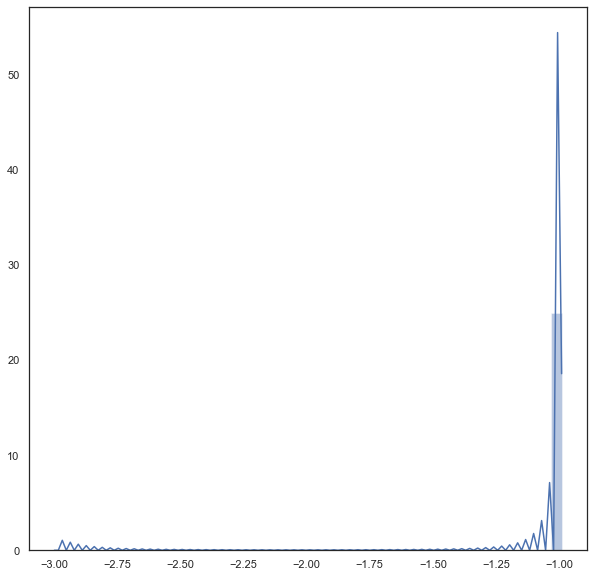

In [14]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.distplot(weights)